##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Chapter 4 - Geocentric Models


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/statistical_rethinking/notebooks/04_geocentric_models"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/04_geocentric_models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/04_geocentric_models.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/examples/statistical_rethinking/notebooks/04_geocentric_models.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Imports and utility functions

In [2]:
#@title Install { display-mode: "form" }
TF_Installation = 'System' #@param ['TF Nightly', 'TF Stable', 'System']

if TF_Installation == 'TF Nightly':
  !pip install -q --upgrade tf-nightly
  print('Installation of `tf-nightly` complete.')
elif TF_Installation == 'TF Stable':
  !pip install -q --upgrade tensorflow
  print('Installation of `tensorflow` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

In [3]:
#@title Install { display-mode: "form" }
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    print("Installing arviz ...")
    !pip install -q arviz

In [4]:
# Core
import collections
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

from scipy.interpolate import BSpline

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [5]:
az.style.use('seaborn-colorblind')

### Sampling helpers

In [6]:
USE_XLA  = False                   #@param

# inference type
# Set USE_MCMC to False if you want to use
# mean field variational inference
USE_MCMC = True                    #@param

In [7]:
def _trace_to_arviz(trace=None,
                    sample_stats=None,
                    observed_data=None,
                    prior_predictive=None,
                    posterior_predictive=None,
                    inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: v.numpy()
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {
            k: v[np.newaxis] for k, v in prior_predictive.items()
        }
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

In [8]:
NUMBER_OF_SAMPLES = 2000           #@param

MCMC_NUMBER_OF_CHAINS  = 2        #@param 
MCMC_NUMBER_OF_BURNIN  = 500      #@param
MCMC_NUMBER_OF_LEAPFROG_STEPS = 4 #@param

VI_LEARNING_RATE = 0.1            #@param
VI_NUMBER_OF_STEPS = 2000         #@param
VI_SAMPLE_SIZE = 1                #@param


@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_hmc_chain(init_state,
                  bijectors, 
                  step_size, 
                  target_log_prob_fn, 
                  num_leapfrog_steps=MCMC_NUMBER_OF_LEAPFROG_STEPS,
                  num_samples=NUMBER_OF_SAMPLES,
                  burnin=MCMC_NUMBER_OF_BURNIN):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size,
    )         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors,
    )       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat    


def sample_posterior_vi(
              jdc, 
              observed_data,
              init_config,
              vi_config=dict(),
              num_samples=NUMBER_OF_SAMPLES):
    
    assert init_config is not None
    
    # expecting the order of keys is same 
    # as that of definition in the model function
    params = init_config.keys()
    
    init_state = dict()
    constraining_bijectors = dict()
    for p in params:
        init_state[p] = init_config[p]['state'][0]
        constraining_bijectors[p] = init_config[p]['bijector']
        
    initial_unconstrained_loc = tf.nest.map_structure(
                lambda b, x: b.inverse(x) if b is not None else x,
                constraining_bijectors, init_state)

    def target_log_prob_fn(*args, **kwargs):
      newargs = []
      for k in params:
        newargs.append(kwargs[k])

      newargs = newargs + list(observed_data)
      return jdc.log_prob(*newargs)
        
    surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
                event_shape=tf.nest.map_structure(tf.shape, init_state),
                constraining_bijectors=constraining_bijectors,
                initial_unconstrained_loc=initial_unconstrained_loc,
                initial_unconstrained_scale=1e-4)  
    
    learning_rate = vi_config.get('learning_rate', VI_LEARNING_RATE)
    num_steps     = vi_config.get('num_steps', VI_NUMBER_OF_STEPS)
    sample_size   = vi_config.get('sample_size', VI_SAMPLE_SIZE)
    
    losses = tfp.vi.fit_surrogate_posterior(
                  target_log_prob_fn,
                  surrogate_posterior=surrogate_posterior,
                  num_steps=num_steps,
                  optimizer=tf.optimizers.Adam(learning_rate),
                  sample_size=sample_size)

    results = surrogate_posterior.sample((MCMC_NUMBER_OF_CHAINS, num_samples))
        
    az_trace = _trace_to_arviz(trace=results)

    return results, az_trace

def sample_posterior_hmc(
              jdc, 
              observed_data,
              init_config,
              mcmc_config=dict(),
              num_samples=NUMBER_OF_SAMPLES):
    
    assert init_config is not None
    
    # expecting the order of keys is same 
    # as that of definition in the model function
    params = init_config.keys()
    
    init_state = []
    bijectors = []
    for p in params:
        init_state.append(init_config[p]['state'])
        bijectors.append(init_config[p]['bijector'])

    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)  
    
    
    step_size  = mcmc_config.get('step_size', 0.1)
    num_chains = mcmc_config.get('num_chains', MCMC_NUMBER_OF_CHAINS)
    burnin     = mcmc_config.get('burnin', MCMC_NUMBER_OF_BURNIN)
    
    results, sample_stats = run_hmc_chain(
        init_state,
        bijectors,
        step_size=step_size,
        target_log_prob_fn=target_log_prob_fn,                                      
        num_samples=num_samples, 
        burnin=burnin,
    )

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))      
        
    transposed_results = []
    
    for r in results:        
        if len(r.shape) == 2:
            transposed_shape = [1,0]
        elif len(r.shape) == 3:
            transposed_shape = [1,0,2] 
        else:
            transposed_shape = [1,0,2,3] 
        
        transposed_results.append(tf.transpose(r, transposed_shape))

    posterior = dict(zip(params, transposed_results))        

    az_trace = _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

    return posterior, az_trace

def sample_posterior(
              jdc, 
              observed_data,
              init_config,
              mcmc_config=dict(),
              vi_config=dict(),
              num_samples=NUMBER_OF_SAMPLES):
    
    if USE_MCMC:
        return sample_posterior_hmc(jdc, observed_data, init_config,mcmc_config,num_samples)
    
    return sample_posterior_vi(jdc, observed_data, init_config,mcmc_config,num_samples)    
    

### Dataset URLs & Utilities

In [9]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"

HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
CHERRY_BLOSSOMS_DATASET_PATH = f"{_BASE_URL}/cherry_blossoms.csv"

In [10]:
# A utility method to convert data (columns) from pandas dataframe
# into tensors with appropriate type
def df_to_tensors(name, df, columns, default_type=tf.float32):
    """ name : Name of the dataset
        df : pandas dataframe
        colums : a list of names that have the same type or
                 a dictionary where keys are the column names and values are the tensorflow type (e.g. tf.float32)
    """
    if isinstance(columns, dict):
        column_names = columns.keys()
        fields = [tf.cast(df[k].values, dtype=v) for k,v in columns.items()]    
    else:
        column_names = columns        
        fields = [tf.cast(df[k].values, dtype=default_type) for k in column_names]    
        
    # build the cls
    tuple_cls = collections.namedtuple(name, column_names)    
    # build the obj
    return tuple_cls._make(fields)      

### Plotting utilities

In [11]:
# a function to plot the density using arviz plot_kde function
def plot_density(positions, x_label='Position', y_label='Density'):
    az.plot_kde(pos)
    plt.xlabel(x_label)
    plt.ylabel(y_label)        

# Introduction

## 4.1. Why normal distributions are normal



### 4.1.1. Normal by addition

Consider a scenario in which you and 999 friends line up on the halfway line of a soccer field. Suppose that each of you has a fair coin, individually tossing the coin 16 times. If the coin comes up heads, one takes a step toward the left-hand goal. For tails, one takes a step to the right-hand goal. To simulate this experiment and measure the distance of each person from the half way line, we can sample from a Uniform distribution, 16 times for each of the 1000 people.

##### Code 4.1



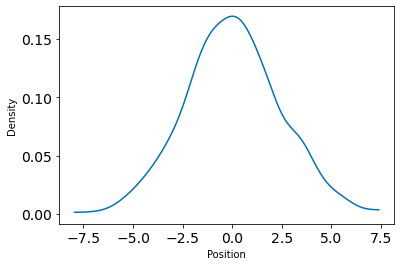

In [12]:
u1 = tfd.Uniform(low=-1.0, high=1.0)
samples = u1.sample(sample_shape=(16,1000))
pos = tf.reduce_sum(samples, axis=0)

plot_density(pos)

Note the Gaussian shape of the distribution, even though the underlying distribution is uniform.

### 4.1.2. Normal by multiplication

> Suppose the growth rate of an organism is influenced by a dozen loci, each with several alleles that code for more growth. Suppose also that all of these loci interact with one another, such that each increase growth by a percentage. This means that their effects multiply, rather than add.

We can use the Uniform distribution for modeling the growth rate from 1 (no growth) to 1.1 (a 10% increase):

##### Code 4.2 



In [13]:
u2 = tfd.Uniform(low=1.0, high=1.1)

We can sample 12 values from this distribution and multiply them together. Let's do this 10000 times and plot the results as a density function.

##### Code 4.3

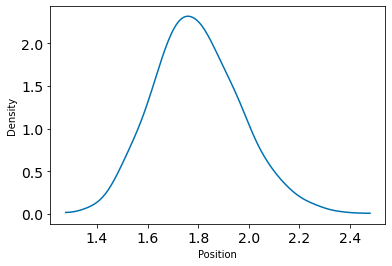

In [14]:
samples = u2.sample(sample_shape=(12,10000))
pos = tf.reduce_prod(samples, axis=0)
plot_density(pos)

If you multiply small effects, the results is close to being additive. Thus, multiplication of these effects will also lead to a Gaussian distribution. In this next example, note that the multiplication of large effects doesn't lead to a Gaussian, while the multiplication of small effects does.

##### Code 4.4

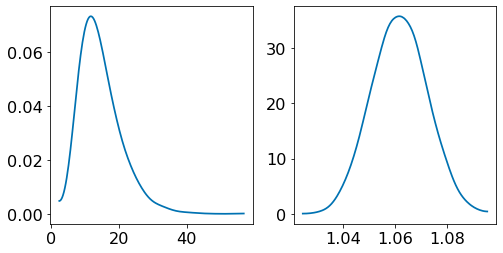

In [15]:
big_samples = tfd.Uniform(low=1.0, high=1.5).sample(sample_shape=(12,10000))
big = tf.reduce_prod(big_samples, axis=0)
small_samples = tfd.Uniform(low=1.0, high=1.01).sample(sample_shape=(12,10000))
small = tf.reduce_prod(small_samples, axis=0)

_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

Yet, large deviations when multipled together will tend to produce Gaussian distributions on a log scale.

### 4.1.3. Normal by log-multiplication

##### Code 4.5

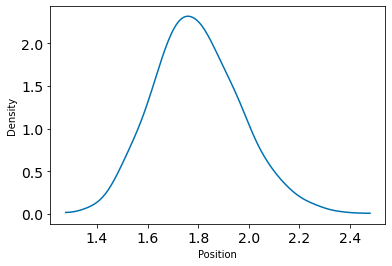

In [16]:
big_samples = tfd.Uniform(low=1.0, high=1.5).sample(sample_shape=(12,10000))
big_product = tf.reduce_prod(big_samples, axis=0)
log_big = tf.math.log(big_product)
plot_density(pos)

## 4.2. A language for describing models

### Overthinking: From model definition to Bayes' theorem.

Recall the variables of the globe-tossing model: 

* $w$ = Observed count of water
* $n$ = Total number of tosses
* $p$ = Proportion of water on the globel

We can define the posterior distribution as:

$$Pr ( p∣w ,n ) = \frac{Binomial(w|n,p) Uniform (p|0,1)}{\int Binomial (w∣n,p) Uniform (p∣0,1) dp}$$

##### Code 4.6



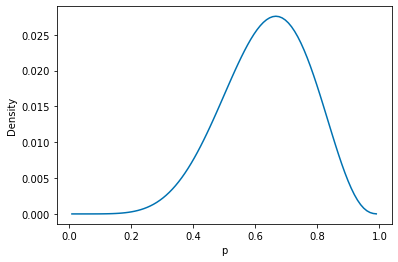

In [17]:
w, n = 6.0, 9.0
 
p_grid = tf.linspace(start=0.,stop=1.,num=100)[1:-1]

b1_dist = tfd.Binomial(total_count=n, probs=p_grid)
u3_dist = tfd.Uniform(low=0.0, high=1.0)

posterior = b1_dist.prob(w) * u3_dist.prob(p_grid)
posterior = posterior / tf.reduce_sum(posterior)

plt.plot(p_grid, posterior)
plt.xlabel('p')
plt.ylabel('Density');

## 4.3. Gaussian model of height

### 4.3.1. The data

We will load census data from the 1960's for the !Kung San foraging population.

##### Code 4.7, 4.8 


We are now building the Gaussian model of height


In [18]:
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


*Here* are some summary statistics for the data:


##### Code 4.9

In [19]:
az.summary(d.to_dict(orient="list"), kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
height,138.264,27.602,90.805,170.180
weight,35.611,14.719,11.368,55.707
age,29.344,20.747,0.000,57.000
male,0.472,0.500,0.000,1.000


For now, we will work with only the height data:

##### Code 4.10

In [20]:
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

In particular, the height of adults only:


##### Code 4.11



In [21]:
d2 = d[d.age >= 18]

### 4.3.2. The model

We will model the heights as a Gaussian distribution, with a uniform prior for the standard deviation and a Gaussian prior for the mean, centered on 178--the author's height.

$h_i$ ~ $Normal(\mu,\sigma)$ [likelihood]

$\sigma$ ~ $Uniform(0,50)$ [$\sigma$ prior]

$\mu$ = $Normal(178,20)$ [$\mu$ prior]

#### Code 4.12 & 4.13



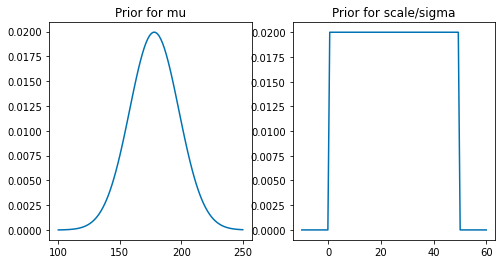

In [22]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

x = tf.linspace(100.0, 250.0, 100)
mu_prior = tfd.Normal(loc=178.0, scale=20.0)
ax1.set_title('Prior for mu')
ax1.plot(x, mu_prior.prob(x));

x = tf.linspace(-10.0, 60.0, 100)
scale_prior = tfd.Uniform(low=0.0, high=50.0)
ax2.set_title('Prior for scale/sigma')
ax2.plot(x, scale_prior.prob(x));

In the above section we have chosen priors for  ℎ ,  𝜇 ,  𝜎 . We can perform a PRIOR PREDICTIVE simulation to see the distribution that these assumptions generate.

**PRIOR PREDICTIVE** simulation is performed by sampling from the prior

#### Code 4.14

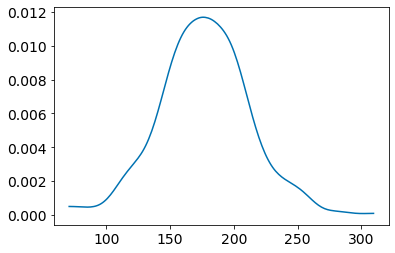

In [23]:
# plot the joint distribution of h, mu and sigma
n_samples = 1000

sample_mu = tfd.Normal(loc=178.0, scale=20.0).sample(n_samples)
sample_sigma = tfd.Uniform(low=0.0, high=50.0).sample(n_samples)
prior_h = tfd.Normal(loc=sample_mu, scale=sample_sigma).sample()

az.plot_kde(prior_h);

Let's see what happens if we increase the standard deviation for `sample_mu` from 20 to 100. 

#### Code 4.15

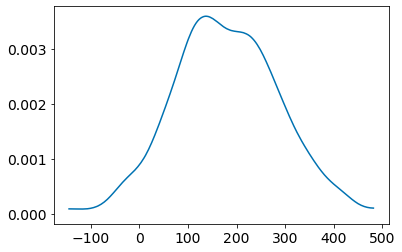

In [24]:
# plot the joint distribution of h, mu and sigma
n_samples = 1000

sample_mu = tfd.Normal(loc=178.0, scale=100.0).sample(n_samples)
sample_sigma = tfd.Uniform(low=0.0, high=50.0).sample(n_samples)
prior_h = tfd.Normal(loc=sample_mu, scale=sample_sigma).sample()

az.plot_kde(prior_h);

Now, what the above plot is showing that there are about 4% of people that have a **negative height** and about 18% on the right side have height not common at all for humans to attain ! So clearly this choice of scale (i.e. 100) is not a good one as the prior. 

### 4.3.3. Grid approximation of the posterior distribution

We can perform a brute-force computation of the posterior distribution, which works best for small models. We can compare this exact computation to a quadratic approximation later in this chapter.

##### Code 4.16

We are here creating a grid of `mu` and `sigma`. In simple words, it means that we are generating all the possible combinations of `mu` and `sigma`.

Since we have 2 dimensions we can represent the above combinations using
a grid. We will use `tf.meshgrid` for that.


In [25]:
def compute_likelihood(mu, sigma, sample_data):
    
    def _compute(i):
        norm_dist = tfd.Normal(loc=mu[i], scale=sigma[i])
        return tf.reduce_sum(norm_dist.log_prob(sample_data))    

    # Note the usage of vectorized_map
    # This essentially runs a parallel loop and makes a difference
    # in the computation of likelihood when the samples size is large
    # which is the case for us
    return tf.vectorized_map(_compute, np.arange(mu.shape[0]))    


def grid_approximation(sample_data, mu_start=150., mu_stop=160., sigma_start=7., sigma_stop=9.):
    mu_list = tf.linspace(start=mu_start, stop=mu_stop, num=200)
    sigma_list = tf.linspace(start=sigma_start, stop=sigma_stop, num=200)
    
    mesh = tf.meshgrid(mu_list, sigma_list)
    mu = tf.reshape(mesh[0], -1)
    sigma = tf.reshape(mesh[1], -1)
    
    log_likelihood = compute_likelihood(mu, sigma, sample_data)

    logprob_mu = tfd.Normal(178.0, 20.0).log_prob(mu)
    logprob_sigma = tfd.Uniform(low=0.0, high=50.0).log_prob(sigma)

    log_joint_prod = log_likelihood + logprob_mu + logprob_sigma
    joint_prob = tf.exp(log_joint_prod - tf.reduce_max(log_joint_prod))
    
    return mesh, joint_prob


In [26]:
mesh, joint_prob = grid_approximation(tf.cast(d2.height.values, dtype=tf.float32))

Display the joint probability using a contour plot:

##### Code 4.17

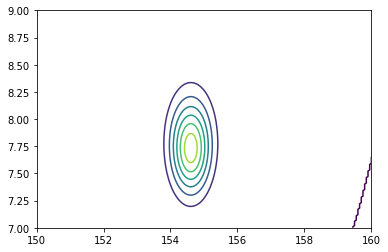

In [27]:
reshaped_joint_prob = tf.reshape(joint_prob, shape=(200,200))
plt.contour(*mesh, reshaped_joint_prob);

We can also using a simple heat map to show where majority of the posterior is:

##### Code 4.18

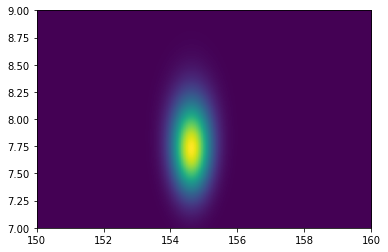

In [28]:
plt.imshow(reshaped_joint_prob,  origin="lower", extent=(150, 160, 7, 9), aspect="auto");

### 4.3.4. Sampling from the posterior

We can sample parameters from the posterior distribution to understand it better. Let's sample combinations of our two parameters, $\mu$ & $\sigma$: we can fetch the parameter values from `sample_rows` sampled by the distribution in our joint probability.

##### Code 4.19 

In [29]:
# This is a trick to sample row numbers randomly with the help of Categorical distribution
posterior_probs = joint_prob / tf.reduce_sum(joint_prob)
sample_rows = tfd.Categorical(probs=(posterior_probs)).sample(1e6)

mu = tf.reshape(mesh[0], -1)
sigma = tf.reshape(mesh[1], -1)

# Fetch mu and sigma from the selected rows
sample_mu = mu.numpy()[sample_rows]
sample_sigma = sigma.numpy()[sample_rows]

Now we have 100,000 samples of $\mu$ & $\sigma$, with replacement, from the posterior for height data. When we plot the samples, we see the highest density of samples in the center: 

##### Code 4.20

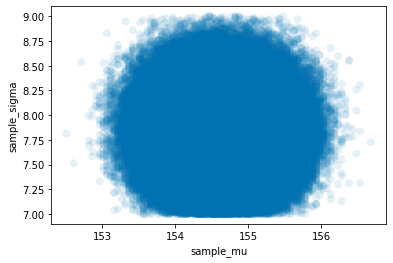

In [30]:
plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none")
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma");

For each of $\mu$ & $\sigma$ we can average over the other parameter, to compute the *marginal* posterior density: 

##### Code 4.21

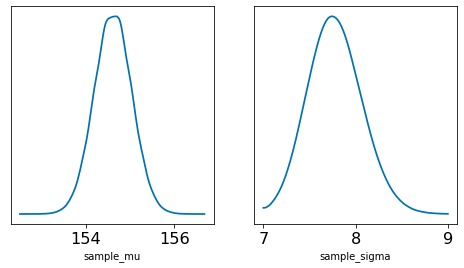

In [31]:
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel('sample_mu')
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel('sample_sigma')
ax[1].set_yticks([]);

As sample size increases, posterior densities approach the *normal distribution*. Here, however, the density for $\sigma$ has a longer right-hand tail, a common shape for standard deviation parameters. 

We can summarize the widths of these densities with **posterior compatibility intervals**:

##### Code 4.22

In [32]:
print("sample_mu -", az.hdi(sample_mu))
print("sample_sigma -", az.hdi(sample_sigma))

sample_mu - [153.76884 155.32663]
sample_sigma - [7.231156 8.316583]


### Overthinking : Sample size and the normality of $\sigma$ 's posterior

When the likelihood and prior on $\mu$ are Gaussian, the posterior distribution of $\mu$ will always Gaussian in shape, regardless of the sample size.

The standard deviation $\sigma$, will tend to have a long tail, however, since variances must be positive. Let's examine a small sample size of 20 of the heights from the data set.

##### Code 4.23

In [33]:
# Repeat our exercise with just 20 samples
d3 = d2.height.sample(n=20)

We'll repeat grid approximation with a small dataset `d3`.

##### Code 4.24

In [34]:
mesh2, joint_prob2 = grid_approximation(
    tf.cast(d3.values, dtype=tf.float32), 
    mu_start=150.,
    mu_stop=170.,
    sigma_start=4.,
    sigma_stop=20.,
)

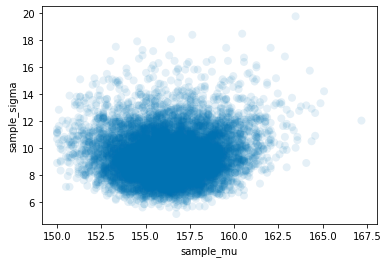

In [35]:
sample2_rows = tfd.Categorical(probs=(joint_prob2/tf.reduce_sum(joint_prob2))).sample(100_00)

mu2 = tf.reshape(mesh2[0], -1)
sigma2 = tf.reshape(mesh2[1], -1)

sample2_mu = mu2.numpy()[sample2_rows]
sample2_sigma = sigma2.numpy()[sample2_rows]

plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none")
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma");

The above plot shows a distinctly longer tail for $\sigma$ at the top of the cloud of points. 

We can inspect the marginal posterior density of $\sigma$, averaging over $\mu$, and vice-versa:

##### Code 4.25

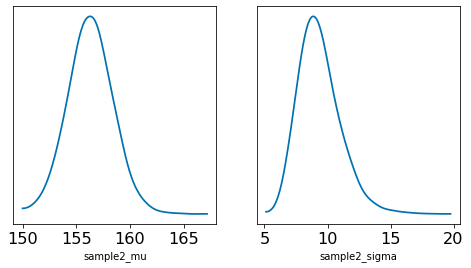

In [36]:
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(sample2_mu, ax=ax[0])
ax[0].set_xlabel('sample2_mu')
ax[0].set_yticks([])
az.plot_kde(sample2_sigma, ax=ax[1])
ax[1].set_xlabel('sample2_sigma')
ax[1].set_yticks([]);


Let's compare our samples of sigma to a normal approximation with the same mean and variance:

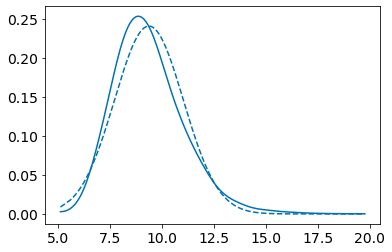

In [37]:
az.plot_kde(sample2_sigma)
x = np.sort(sample2_sigma)
plt.plot(x, np.exp(tfd.Normal(loc=np.mean(x), scale=np.std(x)).log_prob(x)), "--");

As evident from the above plots, while $\mu$ still is Gaussian, the shape of $\sigma$ is not, with a long 
tail of uncertainity towards higher values.

### 4.3.5 Finding the posterior distribution using **quap**

Let's reload our data frame, selecting only adults:

##### Code 4.26



In [38]:
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d2 = d[d.age > 18]
d2

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0


In [39]:
# at this point we also build an object (namedtuple)
# that has tensors that correspond to above dataframe.
tdf = df_to_tensors('Howell1', d2, ['height', 'weight'])




As before, our model definition is:

$h_i$ ~ $Normal(\mu,\sigma)$ 

$\mu$ = $Normal(178,20)$ 

$\sigma$ ~ $Uniform(0,50)$ 

### TFP Rethinking : Probabilistic model definition using JointDistribution*

We are now ready to define our model using tensorflow probability.

As Tensorflow probability offers various methods to define the model, here is a variant
of JointDistribution that uses a syntax based on Python coroutines.

The model is a python function, more specifically a generator function. A generator is a function that has `yield` statements in it, enabling multiple return points. 

We can define a simple model for our height example like this:

```python
def my_model():
    mu = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20.), sample_shape=1))
    likelihood = yield tfd.Independent(tfd.Normal(loc=mu, scale=20.), reinterpreted_batch_ndims=1)
    
jd = tfd.JointDistributionCoroutine(_generator, validate_args=False)  
```

Where you have a distribution, you use the `yield` keyword. A nice side effect is that the distributions and assignments help in cleanly identifying the parts of the model. In subsequent sections, you'll see its significance when we define and use linear models.

We can use the `jd` above to `sample` as well as compute the `log_prob`. In this way, it behaves very similar to any other probability distribution in TFP. Of course, the difference here is that you'll get the `log_prob` of the joint distribution of all the factors in your model, namely the sum of the `log_prob` of all the factors.

We will use a pattern where the generator is actually an inner function: 

```python
def my_model():
    def _generator():
        mu = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20.), sample_shape=1))
        likelihood = yield tfd.Independent(tfd.Normal(loc=mu, scale=20.), reinterpreted_batch_ndims=1)
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

jd = my_model()
```

This style helps in parameterizing our model definition for both data  hyperparameters. Let's see this advantage with the help of a concrete example.

Suppose you want to try different values of `scale` for the likelihood but don't want to re-define the model every time for a change in the value of `scale` (a hyperparameter) in this case.

```python
def my_model(likelihood_scale=20.):
    def _generator():
        mu = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20.), sample_shape=1))        
        likelihood = yield tfd.Independent(tfd.Normal(loc=mu, scale=likelihood_scale), reinterpreted_batch_ndims=1)
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)

jd1 = my_model()  # same behavior as previous definition since likelihood_scale is an optional parameter

jd2 = my_model(likelihood_scale=10.) # we can easily change the hyperparameter of our model
```

The closure that we form with the help of the inner function (our generator) enables such a pattern for model definition that can be easily parameterized for both data and hyperparameters.

Here is our Gaussian model definition of height using [`JointDistributionCoroutine`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionCoroutine):

##### Code 4.27

In [40]:
def model_4_1():
    def _generator():
      mu = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20.), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50.), sample_shape=1))
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_4_1 = model_4_1()

Fitting the model to the data:

##### Code 4.28

In [41]:
init_samples = jdc_4_1.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    mu    = dict(state = init_samples[0], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[1], bijector=tfb.Softplus()) 
)

posterior_4_1, trace_4_1 = sample_posterior(
    jdc_4_1, 
    init_config=init_config,
    observed_data=(tdf.height,)
)

Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.


`sample_posterior` returns a tuple of 2 values. The first one, `posterior_4_1`, is a dictionary containing the posterior samples of our parameters--$\mu$ & $\sigma$ in this model)--using a Hamiltonian Monte Carlo method. The second one, `trace_4_1`, is of type [`InferenceData`](https://arviz-devs.github.io/arviz/generated/arviz.InferenceData.html), used by the `arviz` package to obtain various summary statistics and generate plots

Let's look at the posterior distribution:

##### Code 4.29

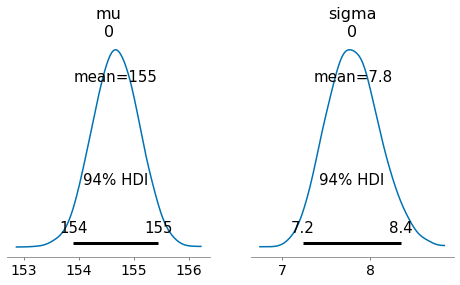

In [42]:
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_posterior(trace_4_1, var_names=['mu', 'sigma'], ax=ax);

In [43]:
az.summary(trace_4_1, round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],154.66,0.42,154.00,155.32,0.01,0.0,3922.82,3922.82,3924.62,3682.44,1.0
sigma[0],7.80,0.30,7.33,8.29,0.00,0.0,14408.24,14408.24,14408.24,3186.97,1.0




> These numbers provide Gaussian approximations for each parameter’s marginal distribution. This means the plausibility of each value of μ, after averaging over the plausibilities of each value of σ, is given by a Gaussian distribution with mean 154.6 and standard deviation 0.4.



### Overthinking: Start values for quap

In the previous sampling for our model parameters $\mu$ & $\sigma$, since we did not specifiy any starting point, the default behavior is to pick values randomly sampled from the prior. It is also possible to specify the initial values. The mean and standard deviation of the dataset are a good choice for initial values.

##### Code 4.30



In [44]:
def use_mean_from_data_as_priors():    
    
    hm = tf.expand_dims(tf.constant([d2.height.mean(), d2.height.mean()], dtype=tf.float32), axis=-1)
    hs = tf.expand_dims(tf.constant([d2.height.std(), d2.height.std()], dtype=tf.float32), axis=-1)
    
    init_config = dict(
        mu    = dict(state = hm, bijector=tfb.Identity()),
        sigma = dict(state = hs, bijector=tfb.Softplus()) 
    )
    
    results = sample_posterior(
        jdc_4_1, 
        observed_data=(tdf.height,), 
        init_config=init_config
    )    
    
use_mean_from_data_as_priors()

The priors we used in above model are very weak: their distribution is fairly flat and there is a lot of data. If we change the standard deviation for the prior of $\mu$ to be 0.1, we can observe the effect of a narrow prior.

##### Code 4.31

In [45]:
def model_4_2():
    def _generator():
      mu = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=0.1), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50.), sample_shape=1))
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_4_2 = model_4_2()

init_samples = jdc_4_2.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    mu    = dict(state = init_samples[0], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[1], bijector=tfb.Softplus()) 
)

posterior_4_2, trace_4_2 = sample_posterior(
    jdc_4_2, 
    init_config=init_config,
    observed_data=(tdf.height,)
)


az.summary(trace_4_2, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
mu[0],177.87,0.10,177.70,178.02
sigma[0],24.54,0.95,23.04,26.05


> Notice that the estimate for μ has hardly moved off the prior. The prior was very concentrated around 178. So this is not surprising. But also notice that the estimate for σ has changed quite a lot, even though we didn’t change its prior at all. Once the golem is certain that the mean is near 178—as the prior insists—then the golem has to estimate σ conditional on that fact. This results in a different posterior for σ, even though all we changed is prior information about the other parameter.

### Sampling from a quap

Our posterior approximation is a multi-dimensional gaussian distribution, in which $\mu$ and $\sigma$ are the two dimensions.
Let's see the covariances between the parameters:

##### Code 4.32

In [46]:
# using only first chain
sample_mu, sample_sigma = posterior_4_1["mu"][0], posterior_4_1["sigma"][0]
sample_mu, sample_sigma = tf.squeeze(sample_mu), tf.squeeze(sample_sigma)
vcov = tfp.stats.covariance(tf.stack([sample_mu, sample_sigma], axis=1))
vcov

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.17429823, 0.00417809],
       [0.00417809, 0.08805176]], dtype=float32)>

`vcov` is called a **VARIANCE-COVARIANCE** matrix. It tells how each parameter relates to every other parameter in the posterior distribution.

> A variance-covariance matrix can be factored into two elements :
* a vector of variances for the parameters
* a correlation matrix that tells us how changes in any parmaeter lead to correlated changes in the others

##### Code 4.33

In [47]:
diag_part = tf.linalg.diag_part(vcov)
print("list of variances for mu and sigma:",diag_part)
print("correlation matrix:",vcov / tf.sqrt(tf.tensordot(diag_part, diag_part, axes=0)))

list of variances for mu and sigma: tf.Tensor([0.17429823 0.08805176], shape=(2,), dtype=float32)
correlation matrix: tf.Tensor(
[[1.         0.03372583]
 [0.03372583 1.        ]], shape=(2, 2), dtype=float32)


Let's retrieve some samples from our multi-dimensional posterior:

##### Code 4.34



In [48]:
sample_mu[:10], sample_sigma[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([154.01648, 154.37129, 154.96921, 154.16539, 154.745  , 154.46898,
        154.16734, 154.95493, 154.36696, 155.0716 ], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([7.858926 , 7.5529814, 7.9850645, 7.8505697, 7.78707  , 7.3489065,
        8.009017 , 7.560805 , 8.246099 , 8.281024 ], dtype=float32)>)

Computing the mean and standard deviation of the samples, we see that the values are similar to the maximum a posteriori values from before:

##### Code 4.35

In [49]:
az.summary({
    'mu' : sample_mu,
    'sigma' : sample_sigma
}, round_to=2, kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.66,0.42,154.01,155.33
sigma,7.80,0.30,7.34,8.29


### Overthinking: Under the hood with multivariate sampling

After we compute the $\mu$ & $\sigma$ for the samples, we can use these values to build a multivariate normal distribution using [`tfp.distributions.MultivariateNormalTriL`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalTriL)


##### Code 4.36

In [50]:
samples_flat = tf.stack([sample_mu, sample_sigma], axis=1)
cov = tfp.stats.covariance(samples_flat)

mu_mean = tf.reduce_mean(sample_mu)
sigma_mean = tf.reduce_mean(sample_sigma)

mu_mean, sigma_mean, cov

(<tf.Tensor: shape=(), dtype=float32, numpy=154.66222>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.8021255>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.17429823, 0.00417809],
        [0.00417809, 0.08805176]], dtype=float32)>)

In [51]:
mvn = tfd.MultivariateNormalTriL(
    loc=[mu_mean, sigma_mean],
    scale_tril=tf.linalg.cholesky(cov))

mvn.sample(1000)

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[155.41006  ,   7.8853593],
       [155.09508  ,   8.683073 ],
       [154.32103  ,   7.618643 ],
       ...,
       [154.13821  ,   8.094601 ],
       [154.07019  ,   7.7891927],
       [154.29112  ,   8.141127 ]], dtype=float32)>

## 4.4 Linear prediction

The models of height that we have defined so far do not have the usual feel of **regression** to them. Now, we'll look at height as an outcome variable with weight as a  **predictor variable** in a linear regression.

When we plot the height of the Kalahari foragers versus their weight, there's a clear relationship between the two:

##### Code 4.37

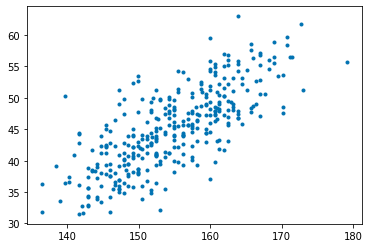

In [52]:
plt.plot(d2.height, d2.weight, ".");

### 4.4.1 The linear model strategy

> The strategy is to make the parameter for the mean of a Gaussian distribution, μ, into a linear function of the predictor variable and other, new parameters that we invent. This strategy is often simply called the **linear model**. The linear model strategy instructs the golem to assume that the predictor variable has a constant and additive relationship to the mean of the outcome. The golem then computes the posterior distribution of this constant relationship

We want to compute the posterior distribution of the infinite possible combinations of parameter values that represent the strength of association between the predictor variables and the outcome variables. 

For the simplest case of a single predictor variable:

$h_i \sim Normal(\mu_i,\sigma)$   [likelihood] 

$\mu_i = \alpha + \beta(x_i - \bar{x})$   [linear model]

$\alpha \sim Normal(178,20)$       [$\alpha$ prior]

$\beta \sim Normal(0,10)$    [$\beta$ prior]      

$\sigma \sim Uniform(0,50)$       [$\sigma$ prior] 


where, $x_i$ are the weight measurements,  $\bar{x}$ is the average of the weights, $\alpha$ is the intercept, and $\beta$ is the slope or rate of change in expectation.

Note the subscript $i$ in the likelihood on $\mu$ as well as $h$, meaning that the mean depends upon values in the row $i$.

We can simulate the variety of lines implied by the priors for $\alpha$ & $\beta$:

##### Code 4.38

In [53]:
# We are simulating a bunch of lines here 
tf.compat.v1.random.set_random_seed(2971)

N = 100

a = tfd.Normal(loc=178.0, scale=20.0).sample(N)
b = tfd.Normal(loc=0., scale=10.0).sample(N)

We have 100 pairs of $\alpha$ & $\beta$ values. Let's plot the lines:

##### Code 4.39

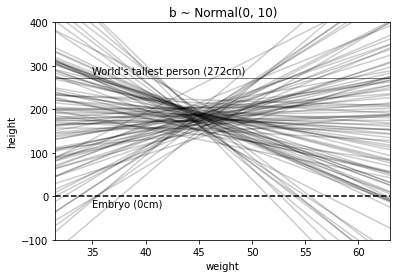

In [54]:
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100, 400),
    xlabel="weight",
    ylabel="height",
)
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2);
    
plt.text(x=35, y=282, s="World's tallest person (272cm)")
plt.text(x=35, y=-25, s="Embryo (0cm)");

'---' shows the shortest possible height, while "____"  shows the height for world's tallest person.

Noting that the lines are showing unnatural relationships between height and weight, we'll now improve the model.

Since we know that average height generally increases with average weight to a certain point, we can restrict $\beta$ to only positive values with a `LogNormal` distribution:

$\beta \sim LogNormal(0,1)$

##### Code 4.40

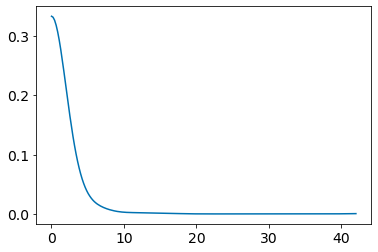

In [55]:
b = tfd.LogNormal(loc=0., scale=1.).sample(1000)
az.plot_kde(b);

With $\beta$ as LogNormal(0,1), our prior predictive simulation yields a much more sensible plot; nearly all lines in the joint prior for $\alpha$ & $\beta$ are now within human reason.

##### Code 4.41

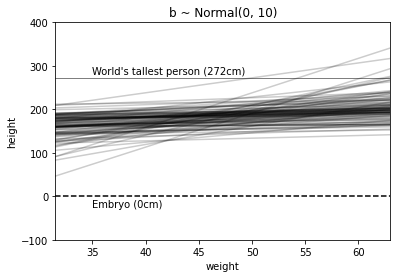

In [56]:
# We are simulating a bunch of lines here, possible relationships
# between height and weight 
tf.compat.v1.random.set_random_seed(2971)

a = tfd.Normal(loc=178.0, scale=20.0).sample(100)
b = tfd.LogNormal(loc=0., scale=1.0).sample(100)

plt.subplot(xlim=(d2.weight.min(), d2.weight.max()), ylim=(-100, 400),
            xlabel="weight", ylabel="height")
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2);
    
plt.text(x=35, y=282, s="World's tallest person (272cm)")
plt.text(x=35, y=-25, s="Embryo (0cm)");

### 4.4.2. Finding the posterior distribution

We can modify our model with a new calculation for the mean and the new parameter $\beta$:

##### Code 4.42

In [57]:
# read the data set
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d2 = d[d.age > 18]

# define the average height
x_bar = tf.constant(d2.weight.mean(), dtype=tf.float32)

tdf = df_to_tensors('Howell1', d2, ['height', 'weight'])

def model_4_3(weight_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20.), sample_shape=1))
      beta  = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=1.0), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50.), sample_shape=1))
    
      mu =  alpha + beta * (weight_data - x_bar)    
    
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_4_3 = model_4_3(tdf.weight)

init_samples = jdc_4_3.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    beta  = dict(state = init_samples[1], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[2], bijector=tfb.Softplus())
)

posterior_4_3, trace_4_3 = sample_posterior(
                                jdc_4_3, 
                                init_config=init_config,
                                observed_data=(tdf.height,))

az.summary(trace_4_3, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],154.66,0.27,154.20,155.06
beta[0],0.91,0.04,0.84,0.97
sigma[0],5.15,0.19,4.85,5.46


### Overthinking: Logs & exps, oh my.

Instead of using a LogNormal prior for $\beta$ we can code it another way. We can define a parameter `log_beta` that is the logarithm of $\beta$, assigning `log_beta` a normal distribution. 

Later, we can reverse the logarithm inside the linear model.

##### Code 4.43 

In [58]:
def model_4_3b(weight_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20.), sample_shape=1))
      # Beta here is normal
      log_beta  = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.0), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50.), sample_shape=1))
    
      # before feeding beta to linear model we are reversing it
      # using the exponential 
      exp_value = tf.cast(tf.exp(log_beta), dtype=tf.float32)
    
      mu =  alpha + exp_value * (weight_data - x_bar)    
    
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_4_3b = model_4_3b(tdf.weight)

init_samples = jdc_4_3b.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    beta  = dict(state = init_samples[1], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[2], bijector=tfb.Softplus())
)


posterior_4_3b, trace_4_3b = sample_posterior(
                                    jdc_4_3b, 
                                    init_config=init_config,
                                    observed_data=(tdf.height,))

Note that in the posterior distribution, instead of getting $\beta$ we will get $log(\beta)$.

### 4.4.3. Interpreting the posterior distribution




We'll start by looking at tables of marginal distributions. `arviz` has a summary method which can use our `trace_4_3` to show not only the mean values for $\alpha$ & $\beta$, but also the credibile interval of 89%.

##### Code 4.44

In [59]:
az.summary(trace_4_3, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],154.66,0.27,154.20,155.06
beta[0],0.91,0.04,0.84,0.97
sigma[0],5.15,0.19,4.85,5.46


(Note that the values in the table above may vary slightly from the ones in the textbook, depending on the execution of the notebook.)

> Since β is a slope, the value 0.90 can be read as *a person 1 kg heavier is expected to be 0.90 cm taller*. 89% of the posterior probability lies between 0.84 and 0.97. That suggests that β values close to zero or greatly above one are highly incompatible with these data and this model. It is most certainly not evidence that the relationship between weight and height is linear, because the model only considered lines. It just says that, if you are committed to a line, then lines with a slope around 0.9 are plausible ones

Let's look at the variance-covariance matrix to understand the posterior distribution better:

---



##### Code 4.45

In [60]:
sample_alpha = tf.squeeze(posterior_4_3["alpha"][0])
sample_beta  = tf.squeeze(posterior_4_3["beta"][0])
sample_sigma = tf.squeeze(posterior_4_3["sigma"][0])

samples_flat = tf.stack([sample_alpha, sample_beta, sample_sigma], axis=1)

cov = tfp.stats.covariance(samples_flat)

alpha_mean = tf.reduce_mean(sample_alpha)
beta_mean  = tf.reduce_mean(sample_beta)
sigma_mean = tf.reduce_mean(sample_sigma)

alpha_mean, beta_mean, sigma_mean, cov

(<tf.Tensor: shape=(), dtype=float32, numpy=154.64487>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.90449464>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.14528>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[ 0.07166237,  0.00013302, -0.00085873],
        [ 0.00013302,  0.0017566 ,  0.00031847],
        [-0.00085873,  0.00031847,  0.0366415 ]], dtype=float32)>)

We see very little covariance among the parameters in this case.

#### 4.4.3.2. Plotting posterior inference against the data.

As an informal check on our model assumptions, we'll plot the height versus weight data, along with the line derived from our model.

##### Code 4.46


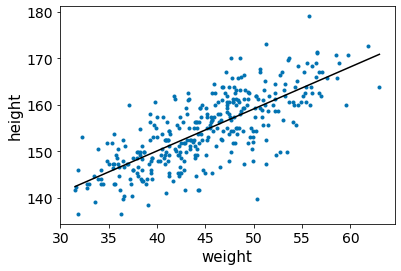

In [61]:
# Let's try just the raw data and a single line

# Raw data is shown using the dots
# The line shows the model that makes use of average values of alpha and beta

az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))

a_map = tf.reduce_mean(sample_alpha)
b_map = tf.reduce_mean(sample_beta)
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
# note - the linear model
plt.plot(x, a_map + b_map * (x - xbar), "k");

In the plot above, we have plotted only the posterior mean line, which tells us about the magnitude of the influence of height on weight, but does not communicate uncertainty. To address this shortcoming, we will look at all possible lines by using the combinations of all of our posterior samples for $\alpha$ & $\beta$.

##### Code 4.47 

In [62]:
summary_dict = {
    'alpha' : sample_alpha, 
    'beta'  : sample_beta,
    'sigma' : sample_sigma
}   

# Looking at a few samples from our posterior
pd.DataFrame.from_dict(summary_dict).head(5)

,alpha,beta,sigma
0,155.129532,0.851108,5.233423
1,155.564575,0.847806,5.374388
2,155.564575,0.847806,5.374388
3,155.019287,0.891147,5.489654
4,154.977936,0.857165,5.137042


Before we plot all of the plausible lines, we can examine the impact of the data on the posterior distribution by first considering only the first 10 cases in the dataset to re-estimate our model.

##### Code 4.48

In [63]:
N = 10
dN = d2[:N]

tdfN = df_to_tensors('Howell1', dN, ['height', 'weight'])

jdc_4_N = model_4_3(dN.weight.values)

init_samples = jdc_4_N.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    beta  = dict(state = init_samples[1], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[2], bijector=tfb.Softplus())
)

posterior_4_N, trace_4_N = sample_posterior(jdc_4_N, 
                              init_config=init_config,
                              observed_data=(tdfN.height,))

az.summary(trace_4_N, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],152.21,1.80,149.51,154.89
beta[0],0.91,0.19,0.62,1.21
sigma[0],5.86,1.97,3.40,8.05


Let's plot 20 of these lines, to see what the uncertainity looks like:

##### Code 4.49 



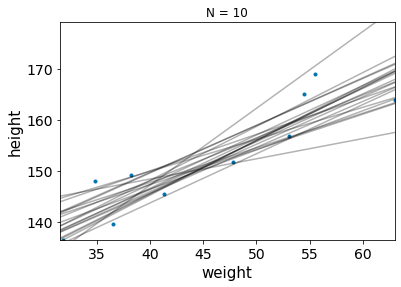

In [64]:
summary_dict_n = {
    'alpha' : tf.squeeze(trace_4_N.posterior['alpha'].values[0]),
    'beta'  : tf.squeeze(trace_4_N.posterior['beta'].values[0]),
    'sigma' : tf.squeeze(trace_4_N.posterior['sigma'].values[0]),
}   

twenty_random_samples = pd.DataFrame.from_dict(summary_dict_n).sample(20).to_dict('list')

# display raw data and sample size
ax = az.plot_pair(dN[["weight", "height"]].to_dict(orient="list"))
ax.set(xlim=(d2.weight.min(), d2.weight.max()),
       ylim=(d2.height.min(), d2.height.max()), title="N = {}".format(N))

# plot the lines, with transparency
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(20):
    plt.plot(x, twenty_random_samples["alpha"][i] + twenty_random_samples["beta"][i] * (x - dN.weight.mean()),
             "k", alpha=0.3)

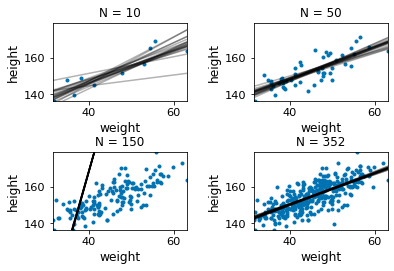

In [65]:
# Note there is no corresponding code in the book but the author recommends to try different
# values of N (10,50, 150, & 352) to show the impact of data
def get_and_plot_posterior_for_different_data_size(data_size, sub_plot):
    N = data_size
    dN = d2[:N]

    tdfN = df_to_tensors('Howell1', dN, ['height', 'weight'])

    jdc_4_N = model_4_3(dN.weight.values)
    
    init_samples = jdc_4_N.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
    init_config = dict(
        alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
        beta  = dict(state = init_samples[1], bijector=tfb.Identity()),
        sigma = dict(state = init_samples[2], bijector=tfb.Exp())
    )
    
    posterior_4_N, trace_4_N = sample_posterior(jdc_4_N, 
                                  init_config=init_config,
                                  observed_data=(tdfN.height,))
    
    summary_dict_n = {
        'alpha' : tf.squeeze(trace_4_N.posterior['alpha'].values[0]),
        'beta'  : tf.squeeze(trace_4_N.posterior['beta'].values[0]),
        'sigma' : tf.squeeze(trace_4_N.posterior['sigma'].values[0]),
    }   

    twenty_random_samples = pd.DataFrame.from_dict(summary_dict_n).sample(20).to_dict('list')

    # display raw data and sample size
    az_plot = az.plot_pair(dN[["weight", "height"]].to_dict(orient="list"), figsize=(4, 4), ax=sub_plot)
    az_plot.set(
           xlim=(d2.weight.min(), d2.weight.max()),
           ylim=(d2.height.min(), d2.height.max()), title="N = {}".format(N))

    # plot the lines, with transparency
    x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
    for i in range(20):
        az_plot.plot(x, 
                twenty_random_samples["alpha"][i] + twenty_random_samples["beta"][i] * (x - dN.weight.mean()),
                "k", alpha=0.3)
        

fig, axes = plt.subplots(2,2)       
fig.tight_layout(pad=3.0)
        
get_and_plot_posterior_for_different_data_size(10, axes[0][0])
get_and_plot_posterior_for_different_data_size(50, axes[0][1])
get_and_plot_posterior_for_different_data_size(150,axes[1][0])
get_and_plot_posterior_for_different_data_size(352,axes[1][1])

The above figure shows that as we increased the amount of the data, the 20 line samples from the posterior distributions grow more confident about the location of the mean. 

We can view the uncertainty about the regression line by plotting an interval around the average regression line. 

We first make a list of 10,000 values of $\mu$ for an individual who weighs 50 kg by using the samples from the posterior:

##### Code 4.50 & 4.51

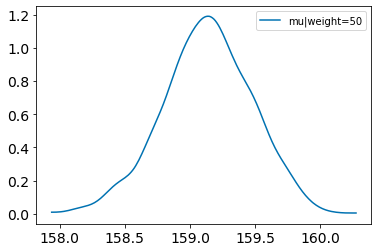

In [66]:
mu_at_50 = summary_dict["alpha"] + summary_dict["beta"] * ( 50 - x_bar )
az.plot_kde(mu_at_50, label="mu|weight=50");


We can compute the 89% compatibility interval of $\mu$ at 50 kg:

##### Code 4.52


In [67]:
az.hdi(mu_at_50.numpy(), hdi_prob=0.89)

array([158.66072, 159.74327], dtype=float32)


Next, we'll repeat the above calculation for 
every weight value instead of  just 50 kg.

The rethinking R package has a *link* method that does it automatically, but here we will do it manually.

##### Code 4.53, 4.54, and 4.55



In [68]:
weight_seq = np.arange(25, 71)
n_samples = len(summary_dict['alpha'])
mu_pred = np.zeros((len(weight_seq), n_samples))
for i, w in enumerate(weight_seq):
    mu_pred[i] = summary_dict['alpha'] + summary_dict['beta'] * (
        w - d2.weight.mean()
    )

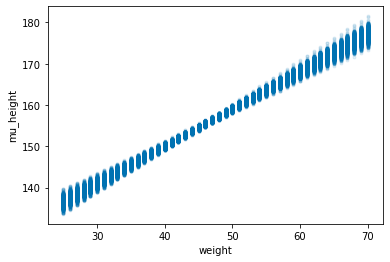

In [69]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("mu_height");

We can see that the amount of uncertainty in $\mu$ depends upon the value of weight. Let's now summarize the distribution for each weight value.

##### Code 4.56

In [70]:
mu_mean = mu_pred.mean(1)
mu_hpd = az.hdi(mu_pred.T, hdi_prob=0.89)

/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tfp-interim/env/lib/python3.7/site-packages/arviz/stats/stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


`mu_mean` contains the average $\mu$ at each weight value

`mu_hpd` contains the 89% lower and upper bounds for each weight value

We now plot these summaries on top of the data.

##### Code 4.57

/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tfp-interim/env/lib/python3.7/site-packages/arviz/stats/stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


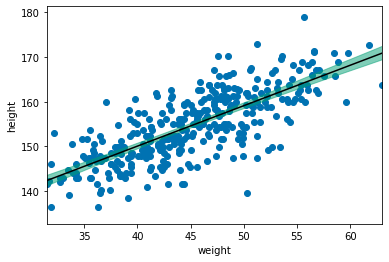

In [71]:
_, axes = plt.subplots(1,1)       
axes.scatter(d2.weight, d2.height)
axes.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());
az.plot_hdi(weight_seq, mu_pred.T, ax=axes);

The shaded region contains the 89% compatibility interval of the mean for height, at each weight value.

##### Code 4.58

(The code snippet in the textbook shows the source code for the *link* function in the R package. You can see the equivalent code in TFP by looking at Code 4.53 to 4.56.)


To generate an 89% prediction interval for **actual heights** instead of just the **average height $\mu$**, we'll need to incorporate $\sigma$ since:

$h_i \sim Normal(\mu_i, \sigma)$


For any unique weight value, we sample from a Gaussian distribution with correct mean $\mu$ for that weight using a value of $\sigma$ sampled from the same posterior distribution. We'll do this sampling for every weight value of interest to create a collection of simulated heights.

### TFP Rethinking : using sample with value kwargs

We can use TFP [`JointDistribution`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistribution) to implement this sampling algorithm for heights based on the posterior distribution of weights.

In earlier examples in this chapter, we used the `sample` method on the object of `JointDistribution` to return the samples of all the distributions included in our model definition. Recall that we can also specify the number of samples to return.

This `sample` method has an another argument--a kwargs actually: `value`. This `value` kwargs takes a list of elements corresponding to the distributions in our model definition. The elements of this list could be either the `tensors` (with same shape as the corresponding distribution) or `None`. For `None`, TFP will use the corresponding distribution to sample, but otherwise use the supplied `tensors` to sample

We will now use this behavior below to sample the heights given the posterior parameters. 

##### Code 4.59

In [72]:
# In this cell we are using posterior samples to compute
# the height for various weights

# use data from only chain 1
sample_alpha = posterior_4_3["alpha"][0]
sample_beta  = posterior_4_3["beta"][0]
sample_sigma = posterior_4_3["sigma"][0]

weight_seq = np.arange(25, 71)

jdc_4_3_weight_seq = model_4_3(weight_seq)

# we are going to essentially sample height for these new weight sequences
# conditioned on our trace


# Note that we are ignoring the first 3 return values as they
# are going to be same as sample_alpha, sample_beta and sample_sigma
# because we have provided their values in the value argument
_, _, _, sim_height = jdc_4_3_weight_seq.sample(value=[
    sample_alpha,
    sample_beta, 
    sample_sigma,
    None  # -> Since we have supplied `None` here, TFP will sample from the corresponding distribution for height
])

We'll now summarize these simulated heights.

##### Code 4.60

In [73]:
height_PI = tfp.stats.percentile(sim_height, q=(5.5, 94.5), axis=0)

Now we can plot everything that we have built up :
    
* The average line
* The shaded region of 89% plausible $\mu$
* The boundaries of simulated heights the model expects

##### Code 4.61

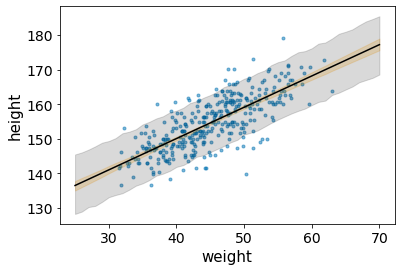

In [74]:
# plot raw data
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"),
    scatter_kwargs={"alpha": 0.5},
)

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_hpd.T[0], mu_hpd.T[1], color="orange", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(
    weight_seq,
    height_PI[0],
    height_PI[1],
    color="k",
    alpha=0.15,
);

The black solid line is the average line for the mean height at each weight. The orange-shaded interval around the line is the 89% plausible region for $\mu$. The wider grey-shaded region represents the region within which the model expects to find 89% of heights in the population, at each weight



The outline for the wide shaded interval is somewhat rough, as it represents the simulation variance in the tails of the sampled Gaussian values. Let's increase the number of samples we take from the posterior distribution in our `sample_posterior` function, and then re-do the code in 4.59-4.61:

##### Code 4.62

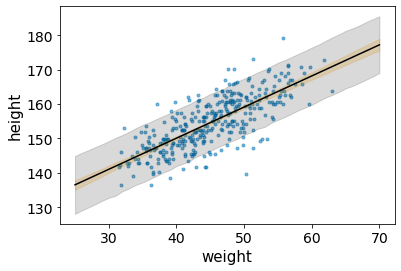

In [75]:
init_samples = jdc_4_3.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    beta  = dict(state = init_samples[1], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[2], bijector=tfb.Softplus())
)

posterior_4_3, trace_4_3 = sample_posterior(
                                jdc_4_3, 
                                observed_data=(tdf.height,), 
                                init_config=init_config,
                                num_samples = 10000)


#re-running Code 4.59 to 4.61
sample_alpha = posterior_4_3["alpha"][0]
sample_beta  = posterior_4_3["beta"][0]
sample_sigma = posterior_4_3["sigma"][0]

weight_seq = np.arange(25, 71)

jdc_4_3_weight_seq = model_4_3(weight_seq)

_, _, _, sim_height = jdc_4_3_weight_seq.sample(value=[
    sample_alpha,
    sample_beta, 
    sample_sigma,
    None 
])
height_PI = tfp.stats.percentile(sim_height, q=(5.5, 94.5), axis=0)

# plot raw data
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"),
             scatter_kwargs={"alpha": 0.5})

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_hpd.T[0], mu_hpd.T[1], color="orange", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(
    weight_seq,
    height_PI[0],
    height_PI[1],
    color="k",
    alpha=0.15,
);

##### Code 4.63
This code snippet in the textbook shows the internals of the author's *sim* function in *R*. We do not need to implement it as this comes free with TFP. See the code cell 4.59 and usage of `value` kwargs of `sample`)

## 4.5 Curves from lines

We will now build models that do not assume that a straight line describes the relationship: In both ***polynomial regression*** and ***b-splines***, a single predictor variable is transformed into several variables.


### 4.5.1 Polynomial regression

Polynomial regression creates curved associations by using the powers of a variable as extra variables.

Let's load the data again but this time using the full data.

##### Code 4.64


In [76]:
hd = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)

hd.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


The most common polynomial regression is a parabolic, second order polynomial. Our model now becomes: 

$h_i \sim Normal(\mu_i,\sigma)$   [likelihood] 

$\mu_i \sim \alpha + \beta_1x_i + \beta_2x_i^2$ [quadratic model] 

$\alpha \sim Normal(178,20)$       [$\alpha$ prior]

$\beta_1 \sim Log-Normal(0,1)$    [$\beta_1$ prior]   

$\beta_2 \sim Normal(0,1)$    [$\beta_2$ prior]     

$\sigma \sim Uniform(0,50)$       [$\sigma$ prior] 




**Standardization** is important in general but it becomes even more important for polynomials. When you square or cube large numbers you end up with even larger variations.


##### Code 4.65  




In [77]:
#standardize the weight measures
hd["weight_std"] = (hd.weight - hd.weight.mean()) / hd.weight.std()
hd["weight_std2"] = hd.weight_std ** 2

tdf = df_to_tensors('Howell1', hd, ['height', 'weight_std', 'weight_std2'])

def model_4_5(weight_data_s, weight_data_s2):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20.), sample_shape=1))
      beta1 = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=1.0), sample_shape=1))
      beta2 = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.0), sample_shape=1))        
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50.), sample_shape=1))
    
      mu =  alpha + beta1 * weight_data_s + beta2 * weight_data_s2  
    
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_4_5 = model_4_5(tdf.weight_std, tdf.weight_std2)

In [78]:
init_samples = jdc_4_5.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    beta1 = dict(state = init_samples[1], bijector=tfb.Identity()),
    beta2 = dict(state = init_samples[2], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[3], bijector=tfb.Softplus())
)

posterior_4_5, trace_4_5 = sample_posterior(
    jdc_4_5,
    observed_data=(tdf.height,),
    num_samples=2000,
    init_config=init_config
)

##### Code 4.66 

In [79]:
az.summary(trace_4_5, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],146.05,0.37,145.49,146.67
beta1[0],21.73,0.28,21.31,22.19
beta2[0],-7.80,0.27,-8.24,-7.38
sigma[0],5.80,0.18,5.51,6.07


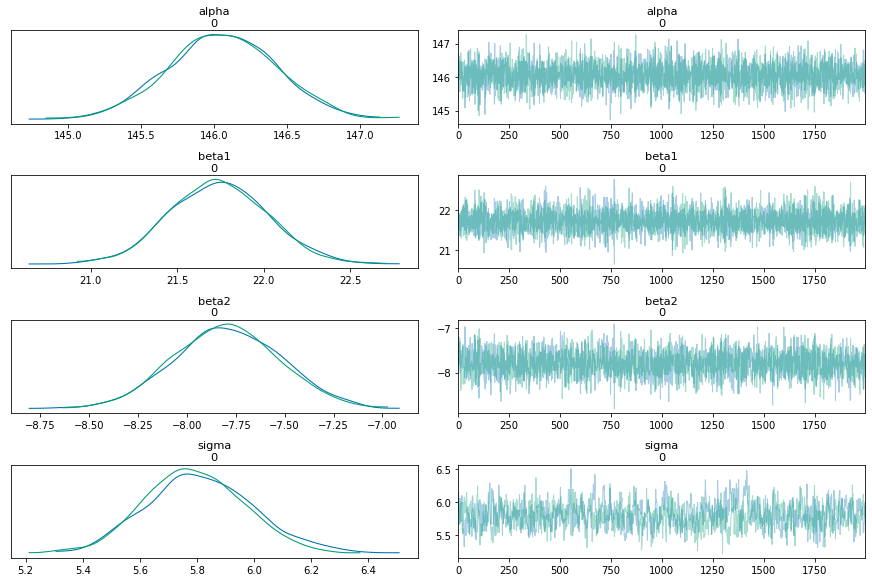

In [80]:
az.plot_trace(trace_4_5);

We will now calculate the mean relatioship and the 89% intervals of the mean and the predictions as we did for the linear model.

### TFP Rethinking : Using sample_distributions

Earlier we described how you could use the `sample` method with its `value` kwargs to simulate the likelihood conditioned on the posterior samples. The situation here is slightly different. We want to compute not only the simulated height (our likelihood), but also $\mu$ using the joint distribution of the posterior parameters.

There is another way to look at it. Since $\mu$ is supplied as the value of the `loc` parameter of the likelihood distribution of our model, if we can get the likelihood (distribution) object we would able be to access it. 

The method that enables this functionality is called [`sample_distributions`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistribution#sample_distributions). It behaves very similar to `sample` and takes a `value` kwargs which expects a list and behaves exactly like that of `sample`--elements of `value` could be `tensors` or `None`. The difference between `sample` & `sample_distributions` is in the return values: `sample_distributions` returns a tuple of size 2:

* The first element is the list of distribution objects parameterized appropriately with the posterior samples we passed as the `value` kwargs

* The second element of the returned tuple is a list of samples, whose elements correspond to the distributions in the model definition. This element is the same as the return value of `sample` method


Since we are interested in the likelihood, the last distribution object in the list,  we can simply access it as the last element of the first element of the returned tuple. Once we have the object, we access its `loc` property to get the $\mu$.

The code cell below shows the usage of `sample_distributions`.

##### Code 4.67

In [81]:
sample_alpha = posterior_4_5["alpha"][0]
sample_beta1 = posterior_4_5["beta1"][0]
sample_beta2 = posterior_4_5["beta2"][0]
sample_sigma = posterior_4_5["sigma"][0]

weight_seq = tf.linspace(start=-2.2, stop=2., num=30)
weight_seq = tf.cast(weight_seq, dtype=tf.float32)

jdc_4_5_weight_seq = model_4_5(weight_seq, weight_seq**2)

# Note - we are using sample_distributions and not sample
# This is because we are interested in accessing the distribution objects as well

ds, samples = jdc_4_5_weight_seq.sample_distributions(value=[
    sample_alpha,
    sample_beta1,
    sample_beta2,
    sample_sigma,
    None
])

# get the distribution object for the likelihood (last element of the first return value)
likelihood = ds[-1].distribution

# get our height samples conditioned on the trace (last element of the second return value)
sim_height = samples[-1]



In [82]:
# getting the loc which is mu
mu_pred = likelihood.loc

# get the average mu
mu_mean = tf.reduce_mean(mu_pred, 0)

# the credible intervals for both mu and simulated height
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)    
height_PI = tfp.stats.percentile(sim_height, q=(5.5, 94.5), axis=0)

##### Code 4.68

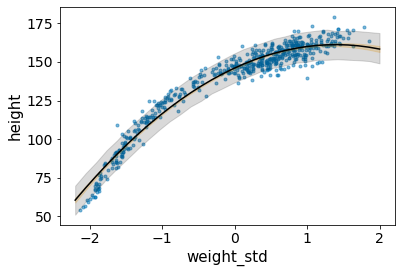

In [83]:
# plot raw data
az.plot_pair(
    hd[["weight_std", "height"]].to_dict(orient="list"),
    scatter_kwargs={"alpha": 0.5},
)

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="orange", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(
    weight_seq,
    height_PI[0],
    height_PI[1],
    color="k",
    alpha=0.15,
 );

In comparison to our linear model from earlier, the quadratic regression has done a better job of finding a central path through the data.

For a higher-order polynomial regression, we'll use a cubic regression on weight:


$h_i \sim Normal(\mu_i,\sigma)$   [likelihood] 

$\mu_i \sim \alpha + \beta_1x_i + \beta_2x_i^2 + \beta_3x_i^3$ [cubic model] 

$\alpha \sim Normal(178,20)$       [$\alpha$ prior]

$\beta_1 \sim Log-Normal(0,1)$    [$\beta_1$ prior]   

$\beta_2 \sim Normal(0,1)$    [$\beta_2$ prior] 

$\beta_3 \sim Normal(0,1)$    [$\beta_3$ prior]

$\sigma \sim Uniform(0,50)$       [$\sigma$ prior] 



##### Code 4.69

In [84]:
hd["weight_std3"] = hd.weight_std ** 3

tdf = df_to_tensors('Howell1', hd, ['height', 'weight_std', 'weight_std2', 'weight_std3'])

def model_4_6(weight_data_s, weight_data_s2, weight_data_s3):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20.), sample_shape=1))
      beta1 = yield Root(tfd.Sample(tfd.LogNormal(loc=0., scale=1.0), sample_shape=1))
      beta2 = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.0), sample_shape=1))        
      beta3 = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.0), sample_shape=1))        
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50.), sample_shape=1))
    
      mu =  alpha + beta1 * weight_data_s + beta2 * weight_data_s2  + beta3 * weight_data_s3
    
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_4_6 = model_4_6(tdf.weight_std, tdf.weight_std2, tdf.weight_std3)

In [85]:
init_samples = jdc_4_6.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    beta1 = dict(state = init_samples[1], bijector=tfb.Identity()),
    beta2 = dict(state = init_samples[2], bijector=tfb.Identity()),
    beta3 = dict(state = init_samples[3], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[4], bijector=tfb.Identity())
)

posterior_4_6, trace_4_6 = sample_posterior(
    jdc_4_6, 
    observed_data=(tdf.height,),
    num_samples=1000,
    init_config=init_config
)

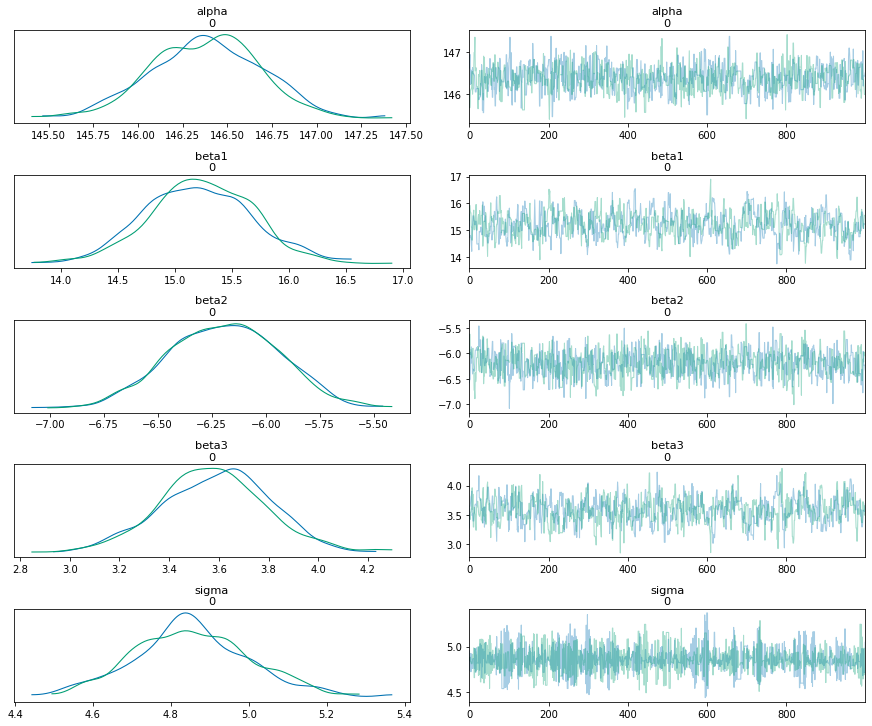

In [86]:
az.plot_trace(trace_4_6);

We can now perform a similar computation to the one we did above for the quadratic model to obtain simulated heights as well the $\mu$ conditioned on the posterior parameters.

##### Code 4.70 & 4.71

In [87]:
sample_alpha = posterior_4_6["alpha"][0]
sample_beta1 = posterior_4_6["beta1"][0]
sample_beta2 = posterior_4_6["beta2"][0]
sample_beta3 = posterior_4_6["beta3"][0]
sample_sigma = posterior_4_6["sigma"][0]

weight_seq = tf.linspace(start=-2.2, stop=2., num=30)
weight_seq = tf.cast(weight_seq, dtype=tf.float32)


jdc_4_6_weight_seq = model_4_6(weight_seq, weight_seq**2, weight_seq**3)

# we are going to essentially sample height for these new weight sequences
# conditioned on our trace
ds, samples = jdc_4_6_weight_seq.sample_distributions(value=[
    sample_alpha, 
    sample_beta1, 
    sample_beta2, 
    sample_beta3, 
    sample_sigma, 
    None
])

# get our height samples conditioned on the trace
sim_height = samples[-1]

# get the distribution object for the likelihood
likelihood = ds[-1].distribution

sim_height.shape

TensorShape([1000, 30])

In [88]:
# getting the loc which is mu
mu_pred = likelihood.loc

mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)    
height_PI = tfp.stats.percentile(sim_height, q=(5.5, 94.5), axis=0)

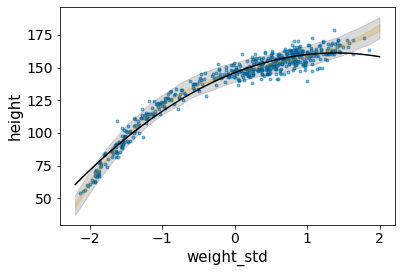

In [89]:
# plot raw data
az.plot_pair(
    hd[["weight_std", "height"]].to_dict(orient="list"),
    scatter_kwargs={"alpha": 0.5},
)

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="orange", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(
    weight_seq,
    height_PI[0],
    height_PI[1],
    color="k",
    alpha=0.15,
);

This cubic curve is even more flexible than the parabola from the quadratic regression, so it fits the data even better. Despite the better fit from the polynomial curvers versus the linear regression, there are 2 clear problems :

1. A better fit to the sample might not be a better model: the subject of Chapter 7.
2. The model is not learning a causal relationship between height & weight: The subject of Chapter 16.

### 4.5.2 Splines

Splines are another way to construct the curve. Of the many types of splines, we'll examine the simplest, called a **B-Spline**.

Here, we use a dataset of 1000+ years of when cherry trees blossom in Japan. The *doy* is the first day of blossom, meaning the number of days since January 1 of that year.

##### Code 4.72

In [90]:
d = pd.read_csv(CHERRY_BLOSSOMS_DATASET_PATH, sep=';', header=0)

d.describe()

,year,doy,temp,temp_upper,temp_lower
count,1215.000000,827.000000,1124.000000,1124.000000,1124.000000
mean,1408.000000,104.540508,6.141886,7.185151,5.098941
std,350.884596,6.407036,0.663648,0.992921,0.850350
min,801.000000,86.000000,4.670000,5.450000,0.750000
25%,1104.500000,100.000000,5.700000,6.480000,4.610000
50%,1408.000000,105.000000,6.100000,7.040000,5.145000
75%,1711.500000,109.000000,6.530000,7.720000,5.542500
max,2015.000000,124.000000,8.300000,12.100000,7.740000


In [91]:
az.summary(d.to_dict(orient="list"), kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
year,1408.0,350.885,801.00,1882.0
doy,NaN,NaN,86.00,NaN
temp,NaN,NaN,5.06,NaN
temp_upper,NaN,NaN,5.78,NaN
temp_lower,NaN,NaN,3.60,NaN


> The short explanation of B-splines is that they divide the full range of some predictor variable, like year, into parts. Then they assign a parameter to each part. These parameters are gradually turned on and off in a way that makes their sum into a fancy, wiggly curve. The long explanation contains lots more details. But all of those details just exist to achieve this goal of building up a big, curvy function from individually less curvy local functions.

Knots are values of the year that serve as pivots for our spline and the basis functions $\beta$ which we combine to compute the spline via a linear model:


$\mu_i = \alpha + w_1\beta_{i,1}+ w_21\beta_{i,2} + w_3\beta_{i,3}$ + ...



We will be using 15 of these pivots. Where should we place these pivots? They can be put anywhere in principle. Finding the locations of them can be considered part of modeling, similar to   hyperparameters.

Here, we are placing them at different evenly spaced quantiles of the predictor variable--the year. 


##### Code 4.73


In [92]:
d2 = d[d.doy.notna()]  # not NaN cases on doy
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

# notice that there are 15 evenly spaced dates ()
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

Next we need to decide on the polynomial degree. For degree of *n*, *n*+1 functions combine at each value of the predictor variable.

`scipy` provides an implementation for constructing the BSplines given knots and degree of freedom.

Below, in `BSpline` we are using degree `k`=3.

##### Code 4.74

In [93]:
knots = np.pad(knot_list, (3, 3), mode="edge")
B = BSpline(knots, np.identity(num_knots + 2), k=3)(d2.year.values)

In [94]:
#each row is a year, each column is a basis function
B.shape

(827, 17)

Here, we depict the four basis functions:

##### Code 4.75

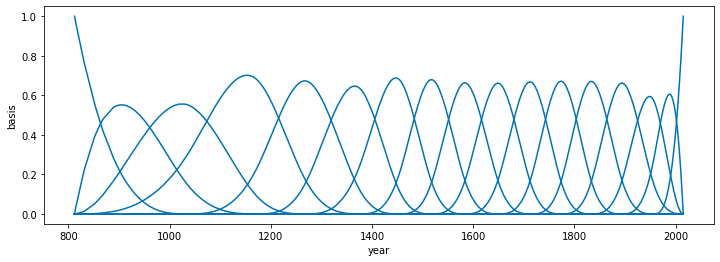

In [95]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(17):
    ax.plot(d2.year, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis");

We now define our model as a linear regression. Columns in our `B` matrix correspond to the synthetic variables in our regression model. Our model also includes an intercept $\alpha$ to capture the average temperature.

##### Code 4.76



In [96]:
tdf = df_to_tensors('Cherry', d2, ['doy'])

def model_4_7():
    alpha = yield Root(tfd.Sample(tfd.Normal(loc=100.0, scale=10.0, name='alpha'), sample_shape=1))
    w = yield Root(tfd.Sample(tfd.Normal(loc=0.0, scale=10.0, name='w'), sample_shape=17))
    sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name='sigma'), sample_shape=1))
    
    B_x = tf.cast(B, dtype=tf.float32)    
    mu = alpha + tf.einsum("ij,...j->...i", B_x, w)     
   
    temp = yield tfd.Independent(
        tfd.Normal(loc=mu, scale=sigma, name='D'),
        reinterpreted_batch_ndims=1,
    )
   
jdc_4_7 = tfd.JointDistributionCoroutine(model_4_7, validate_args=False)

alpha_sample, w_sample, sigma_sample, doy_sample = jdc_4_7.sample(2)

In [97]:
init_samples = jdc_4_7.sample(MCMC_NUMBER_OF_CHAINS)[:-1]
init_config = dict(
    alpha = dict(state = init_samples[0], bijector=tfb.Identity()),
    w     = dict(state = init_samples[1], bijector=tfb.Identity()),
    sigma = dict(state = init_samples[2], bijector=tfb.Exp())
)

mcmc_config = dict(burnin=1000)

posterior_4_7, trace_4_7 = sample_posterior(
    jdc_4_7, 
    num_samples=4000, 
    observed_data=(tdf.doy,),
    init_config=init_config,
    mcmc_config=mcmc_config
)

Note - Make sure that r_hat below is around 1 else run the above cell few times. The sampling from this posterior has been very inconsistent so far.

In [98]:
az.summary(trace_4_7, round_to=2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],103.83,0.80,102.75,104.96,0.55,0.46,2.14,2.14,2.55,16.18,2.32
w[0],2.17,3.98,-2.41,7.22,2.80,2.36,2.02,2.02,2.47,18.53,2.33
w[1],3.92,1.07,2.23,5.45,0.62,0.49,2.93,2.93,3.12,12.60,1.74
w[2],-6.50,6.61,-15.54,0.81,4.64,3.92,2.03,2.03,2.38,18.50,2.62
w[3],2.10,3.17,-2.13,6.35,2.14,1.78,2.19,2.19,2.33,10.94,2.72
w[4],0.51,8.64,-10.18,10.38,6.09,5.15,2.01,2.01,2.31,11.96,2.98
w[5],-5.69,1.99,-8.23,-2.68,1.36,1.14,2.14,2.12,2.39,10.97,2.54
w[6],7.53,3.86,3.35,13.87,2.64,2.20,2.14,2.14,2.37,10.89,2.56
w[7],-4.01,3.89,-9.83,1.27,2.70,2.26,2.08,2.08,2.26,12.05,3.02
w[8],5.79,2.73,1.83,10.05,1.86,1.56,2.14,2.14,2.26,10.90,2.97


Above, we have 17 `w` parameters, for each of our 15 basis functions in the model, plus the start and end values. As the table summary here is challenging to interpret, we will plot the posterior predictions to understand them better.

##### Code 4.77 

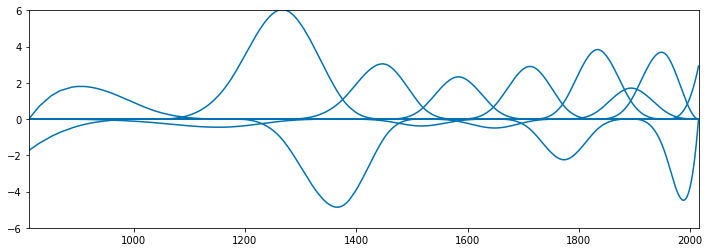

In [99]:
sample_alpha = tf.squeeze(posterior_4_7["alpha"][0])
sample_w     = tf.squeeze(posterior_4_7["w"][0])
sample_sigma = tf.squeeze(posterior_4_7["sigma"][0])

w = sample_w.numpy().mean(0)

_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(17):
    ax.plot(d2.year, (w[i] * B[:, i]), color="C0")
ax.set_xlim(812, 2015)
ax.set_ylim(-6, 6);

Above is the plot of each basis function--the basis value weighted by its corresponding parameter. 

Lastly, we depict the 97% posterior interval for $\mu$ at each year.

##### Code 4.78

/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tfp-interim/env/lib/python3.7/site-packages/arviz/stats/stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


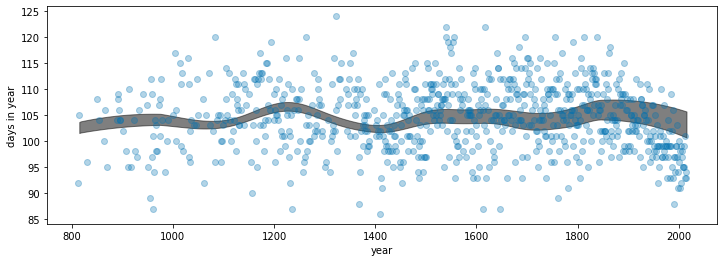

In [100]:
B_x = tf.cast(B, dtype=tf.float32)    
mu_pred = sample_alpha[...,tf.newaxis] + tf.einsum("ij,...j->...i", B_x, sample_w)

_, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(d2.year, d2.doy, "o", alpha=0.3)
az.plot_hpd(d2.year, mu_pred, color="k", ax=ax)
ax.set_xlabel("year")
ax.set_ylabel("days in year");

This plot shows the sum of the weighted basis function at each point: the b-spline function.